## Analyse data from joy et al. 2021 GRL

### Procedure
- Use the dynamic atmospheric transport control data for Point Barrow (where eveything is variable). See file names.
- Aggregate data in yearly files into a pandas dataframe
- Calculate monthly means
- Read in Point Barrow observations data
- Plot simulated vs observed CO2 (Joyce figure S8)
- Apply ccgcrv to observed and simulations to get a fit to seasonal CO2
- Calculate CO2 seasonal amplitude changes and plot

In [2]:
# Set python environment to conda 'recovery' 
import pandas as pd
from pathlib import Path
import os
from glob import glob
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read in files
file_brw_obs = Path("../data/stations/monthly_comp/BRW_station_co2_observed_insitu.csv")
file_brw_joyce_varyall = Path("../data/stations/monthly_comp/BRW_station_co2_joyce_varyall.csv")
brw_obs = pd.read_csv(file_brw_obs, header=0, names=['decimal_year', 'co2_obs'])
brw_jva = pd.read_csv(file_brw_joyce_varyall, header=0, names=['decimal_year', 'co2_joyce'])

In [4]:
# Merge the data
co2_brw = pd.merge(brw_obs, brw_jva, on="decimal_year")

In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

X = co2_brw.loc[:, 'decimal_year'].values.reshape(-1, 1) # sklearn fit requires a two dimensional array

nna = co2_brw["co2_obs"].notna()
y = co2_brw.loc[nna, 'co2_obs'].values.reshape(-1, 1)
model.fit(X[nna], y)
y_predict = model.predict(X)
co2_brw['co2_obs_tr'] = pd.Series(y_predict.reshape(-1))
co2_brw['co2_obs_dt'] = co2_brw['co2_obs'] - co2_brw['co2_obs_tr']

nna = co2_brw["co2_obs"].notna()
y = co2_brw.loc[nna, 'co2_joyce'].values.reshape(-1, 1)
model.fit(X[nna], y)
y_predict = model.predict(X)
co2_brw['co2_joyce_tr'] = pd.Series(y_predict.reshape(-1))
co2_brw['co2_joyce_dt'] = co2_brw['co2_joyce'] - co2_brw['co2_joyce_tr']
co2_brw.to_csv('co2_brw.csv')

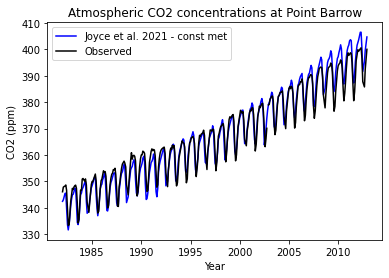

In [6]:
# Plot time series
plt.close()
plt.plot(co2_brw['decimal_year'], co2_brw['co2_joyce'], color='blue', label='Joyce et al. 2021 - const met')
plt.plot(co2_brw['decimal_year'], co2_brw['co2_obs'], color='black', label='Observed')
plt.title('Atmospheric CO2 concentrations at Point Barrow')
plt.legend(loc="upper left")
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

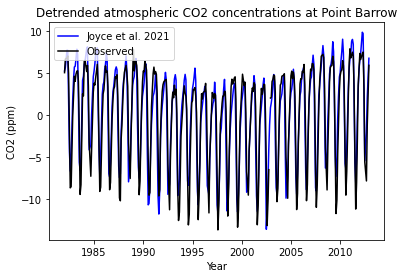

In [7]:
plt.clf()
plt.plot(co2_brw['decimal_year'], co2_brw['co2_joyce_dt'], color='blue', label='Joyce et al. 2021')
plt.plot(co2_brw['decimal_year'], co2_brw['co2_obs_dt'], color='black', label='Observed')
plt.legend(loc="upper left")
plt.title('Detrended atmospheric CO2 concentrations at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

### Fitting ccgcrv

In [8]:
# Define a function that calls the ccgcrv fit

def fit_ccgcrv(xp, yp, pars):
    # Prepares data and calls the ccgcrv fitting function
    # xp and yp are pandas Series (DataFrame columns)
    # pars is a dictionary of parameter values
    
    from ccgcrv_python import ccg_filter

    nna = yp.notna() # Need to remove missing values!
    xp = xp[nna].to_numpy()
    yp = yp[nna].to_numpy()

    # create the ccgfilt object
    filt = ccg_filter.ccgFilter(
        xp=xp, yp=yp, shortterm=pars['shortterm'], 
        longterm=pars['longterm'], sampleinterval=pars['sampleinterval'],
        numpolyterms=pars['numpolyterms'], numharmonics=pars['numharmonics'],
        timezero=pars['timezero'], gap=pars['gap'], debug=pars['debug']
        )

    mm = filt.getMonthlyMeans()
    amps = filt.getAmplitudes()
    tcup, tcdown = filt.getTrendCrossingDates()

    # get x,y data for plotting
    x0 = filt.xinterp
    y1 = filt.getFunctionValue(x0)
    y2 = filt.getPolyValue(x0)
    y3 = filt.getSmoothValue(x0)
    y4 = filt.getTrendValue(x0)
    
    data_in = pd.DataFrame(data=np.array([xp, yp]).transpose(), columns=['year_dec', 'co2'])
    mod_out = pd.DataFrame(data=np.array([x0,y1,y2,y3,y4]).transpose(), columns=['year_dec', 'fit', 'poly', 'smooth', 'trend'])
    amplitude = pd.DataFrame(amps, columns=['year', 'amplitude', 'max_date', 'max_value', 'min_date', 'min_value'])
    tcross = pd.DataFrame(list(zip(tcup, tcdown)), columns=['tcup', 'tcdown'])
    out = {'data_in': data_in, 'model_out': mod_out, 'monthly_mean': mm, 'amplitude': amplitude, 'trend_cross': tcross}
    return(out)


In [9]:
# Set parameters and input data and call the ccgcrv function
pars = {
    'shortterm': 80,
    'longterm': 667,
    'sampleinterval': 30,
    'numpolyterms': 3,
    'numharmonics': 4,
    'timezero': -1,
    'gap': 0,
    'use_gain_factor': False,
    'use_gain_factor': False,
    'debug': False
}

co2_brw = pd.read_csv('co2_brw.csv')

ccgfit_obs = fit_ccgcrv(xp=co2_brw["decimal_year"], yp=co2_brw["co2_obs"], pars=pars)
ccgfit_joyce = fit_ccgcrv(xp=co2_brw["decimal_year"], yp=co2_brw["co2_joyce"], pars=pars)


### Plots of ccgcrv outputs

In [25]:
# Extract data from outputs
fit_obs = ccgfit_obs['model_out']
data_obs = ccgfit_obs['data_in']
amp_obs = ccgfit_obs['amplitude']
tcross_obs = ccgfit_obs['trend_cross']

fit_joyce = ccgfit_joyce['model_out']
data_joyce = ccgfit_joyce['data_in']
amp_joyce = ccgfit_joyce['amplitude']
tcross_joyce = ccgfit_joyce['trend_cross']


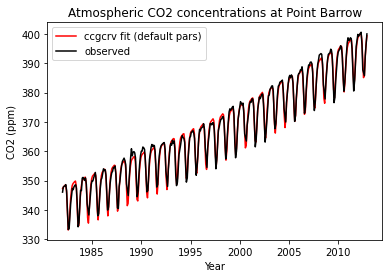

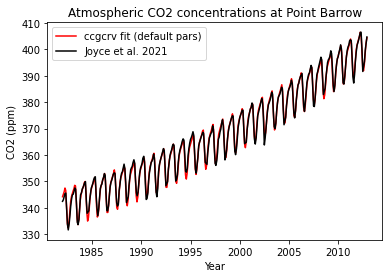

In [33]:
# Plot time series of CO2 values
plt.plot(fit_obs['year_dec'], fit_obs['fit'], color="red", label='ccgcrv fit (default pars)')
plt.plot(data_obs['year_dec'], data_obs['co2'], color="black", label='observed')
plt.legend(loc="upper left")
plt.title('Atmospheric CO2 concentrations at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

plt.plot(fit_joyce['year_dec'], fit_joyce['fit'], color="red", label='ccgcrv fit (default pars)')
plt.plot(data_joyce['year_dec'], data_joyce['co2'], color="black", label='Joyce et al. 2021')
plt.legend(loc="upper left")
plt.title('Atmospheric CO2 concentrations at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

In [ ]:
# Plot time series of CO2 seasonal amplitudes
plt.plot(amp_obs['year'], amp_obs['amplitude'], color="blue", label='observed (ccgcrv default pars)')
plt.plot(amp_joyce['year'], amp_joyce['amplitude'], color="red", label='Joyce et al. 2021 (ccgcrv default pars)')
plt.legend(loc="upper left")
plt.title('CO2 seasonal amplitude at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

**Plots of trend crossing dates**

In [46]:
# Convert from decimal year to date
def decyear_todate(decyear):
    from datetime import datetime, timedelta
    year = int(decyear)
    rem = decyear - year
    base = datetime(year, 1, 1)
    date = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    return(date)

tcross_obs['tcup_date'] = pd.to_datetime(tcross_obs['tcup'].transform(decyear_todate)).round('D')
tcross_obs['tcdown_date'] = pd.to_datetime(tcross_obs['tcdown'].transform(decyear_todate)).round('D')
tcross_obs['tcup_doy'] = tcross_obs['tcup_date'].dt.strftime('%j').astype(int)
tcross_obs['tcdown_doy'] = tcross_obs['tcdown_date'].dt.strftime('%j').astype(int)

tcross_joyce['tcup_date'] = pd.to_datetime(tcross_joyce['tcup'].transform(decyear_todate)).round('D')
tcross_joyce['tcdown_date'] = pd.to_datetime(tcross_joyce['tcdown'].transform(decyear_todate)).round('D')
tcross_joyce['tcup_doy'] = tcross_joyce['tcup_date'].dt.strftime('%j').astype(int)
tcross_joyce['tcdown_doy'] = tcross_joyce['tcdown_date'].dt.strftime('%j').astype(int)

tcross_year = tcross_obs['tcdown_date'].dt.strftime('%Y').astype(int)


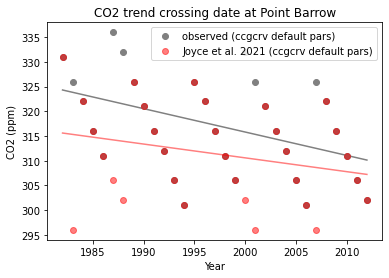

In [57]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

x = tcross_year.values.reshape(-1, 1) # sklearn fit requires a two dimensional array
y = tcross_obs['tcup_doy'].values.reshape(-1, 1) # sklearn fit requires a two dimensional array
model.fit(x, y)
y_pred = model.predict(x)
plt.plot(x, y, 'o', color="grey", alpha=1,label='observed (ccgcrv default pars)')
plt.plot(x, y_pred, color="grey")

x = tcross_year.values.reshape(-1, 1) # sklearn fit requires a two dimensional array
y = tcross_joyce['tcup_doy'].values.reshape(-1, 1) # sklearn fit requires a two dimensional array
model.fit(x, y)
y_pred = model.predict(x)
plt.plot(x, y, 'o', color="red", alpha=0.5, label='Joyce et al. 2021 (ccgcrv default pars)')
plt.plot(x, y_pred, color="red", alpha=0.5)

plt.legend(loc="upper right")
plt.title('CO2 trend crossing date at Point Barrow')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.show()

Text(15, 17, 'r-squared = 0.209')

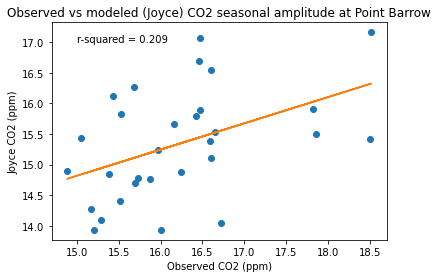

In [ ]:
# Regression plots
from sklearn.linear_model import LinearRegression
model = LinearRegression()
x = amp_obs['amplitude'].values.reshape(-1, 1) # sklearn fit requires a two dimensional array
y = amp_joyce['amplitude'].values.reshape(-1, 1) # sklearn fit requires a two dimensional array
model.fit(x, y)
y_pred = model.predict(x)
plt.plot(x, y, 'o')
plt.plot(x, y_pred)
plt.title('Observed vs modeled (Joyce) CO2 seasonal amplitude at Point Barrow')
plt.ylabel('Joyce CO2 (ppm)')
plt.xlabel('Observed CO2 (ppm)')
plt.annotate("r-squared = {:.3f}".format(model.score(x, y)), (15, 17))
